Here we try to simulate proteoform mixtures as discussed during the Lorentz center conference on Computational Proteomics.

A simulations only including 2 proteoforms.  
First some constants. 

In [26]:
number_of_replicates = 3
number_of_conditions = 2
number_of_shared_peptides = 3
number_of_uniq_peptides_per_proteoform = 5
number_of_peptides = number_of_uniq_peptides_per_proteoform*2 + number_of_shared_peptides

Also we define the proteoform concentrations for each condition

In [27]:
prot1_per_condition = [1.0, 1.0] # A, B
prot2_per_condition = [0.1, 10.0]

Each peptide will have a ionization efficency that we assume is log-normal distributed.

In [28]:
ionization_mu, ionization_sigma = 3., 5.

Here we introduce a noise model, which adds normal distributed noise with a standard deviation proportional to the signal, but with a minimal stdv.

In [29]:
import numpy as np

noise_proportionality = 0.2
noise_min = 0.1

rng = np.random.default_rng()

def add_noise(raw):
    stdv = max(noise_min, raw * noise_proportionality)
    noise = rng.normal(0., stdv)
    return abs(raw + noise) # guard ourseves from negative values
    
add_noise_v = np.vectorize(add_noise)

Given these constraints we can now simulate peptide concentrations.

In [30]:
peptide_conc_A = np.asarray([prot1_per_condition[0]]*number_of_uniq_peptides_per_proteoform + \
                 [prot1_per_condition[0]+prot2_per_condition[0]]*number_of_shared_peptides + \
                 [prot2_per_condition[0]]*number_of_uniq_peptides_per_proteoform)

peptide_conc_B = np.asarray([prot1_per_condition[1]]*number_of_uniq_peptides_per_proteoform + \
                 [prot1_per_condition[1]+prot2_per_condition[1]]*number_of_shared_peptides + \
                 [prot2_per_condition[1]]*number_of_uniq_peptides_per_proteoform)

peptide_conc = np.vstack((np.tile(peptide_conc_A, (number_of_replicates, 1)),\
                          np.tile(peptide_conc_B, (number_of_replicates, 1))))


And then we apply ionization efficency and noise

In [31]:
ionization = rng.lognormal(ionization_mu, ionization_sigma, number_of_peptides)
peptide_abundance_raw = np.multiply(ionization,peptide_conc)
peptide_abundance = add_noise_v(peptide_abundance_raw)

<AxesSubplot:>

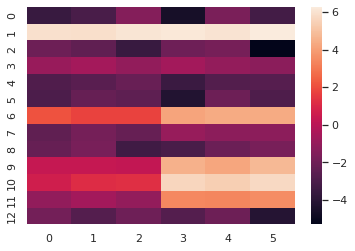

In [32]:
import seaborn as sns; sns.set_theme()
sns.heatmap(np.log(peptide_abundance.T))
